# مشروع التخرج النهائي
## نظام تصنيف تذاكر الدعم الفني وتحليل المشاعر
هذا المستند يشرح خطوات تنفيذ المشروع من البداية حتى النهاية مع الكود.

### المرحلة 0: تثبيت المتطلبات
في هذه المرحلة نقوم بتثبيت المكتبات اللازمة للمشروع.

In [1]:
# تثبيت المكتبات الضرورية
!pip install transformers datasets imbalanced-learn scikit-learn matplotlib ipywidgets


### المرحلة 1: استيراد المكتبات وإعداد البيئة
- استيراد المكتبات الأساسية مثل pandas و torch و transformers
- ضبط Seed لضمان قابلية إعادة الإنتاج
- اختيار الجهاز (GPU أو CPU)

In [2]:
import os, random, re, string
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from imblearn.over_sampling import SMOTE
from transformers import (
    BertTokenizerFast, BertForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback,
    pipeline as hf_pipeline
)
from datasets import Dataset

import ipywidgets as widgets
from IPython.display import display, clear_output

# ضبط الـ SEED
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# اختيار الجهاز
device = "cuda" if torch.cuda.is_available() else "cpu"
print("الجهاز المستخدم:", device)


الجهاز المستخدم: cuda


### المرحلة 2: تحميل البيانات ومعالجتها
1. قراءة ملف CSV
2. دمج عمودي subject و body في عمود نصي جديد
3. تنظيف النصوص (حروف صغيرة، إزالة ترقيم، فراغات)

In [3]:
# قراءة البيانات
df = pd.read_csv("dataset-tickets-multi-lang-4-20k.csv")

# دمج النصوص
df['text'] = df['subject'].fillna('') + " " + df['body'].fillna('')

# دالة تنظيف النص
def clean_text(s):
    s = s.lower()
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# تطبيق التنظيف
df['clean_text'] = df['text'].astype(str).apply(clean_text)

print("شكل البيانات بعد المعالجة:", df.shape)
df.head(3)


شكل البيانات بعد المعالجة: (20000, 17)


,subject,body,answer,type,queue,priority,language,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,text,clean_text
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,Ich werde Ihnen bei der Lösung des Problems he...,Incident,General Inquiry,low,de,Crash,Technical,Bug,Hardware,Resolution,Outage,Documentation,NaN,Unvorhergesehener Absturz der Datenanalyse-Pla...,unvorhergesehener absturz der datenanalyseplat...
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback,Sales,IT,Tech Support,NaN,NaN,NaN,NaN,Customer Support Inquiry Seeking information o...,customer support inquiry seeking information o...
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,en,Technical,Product,Guidance,Documentation,Performance,Feature,NaN,NaN,Data Analytics for Investment I am contacting ...,data analytics for investment i am contacting ...


### المرحلة 3: معالجة عدم توازن الفئات
نعيد تكرار الصفوف لكل فئة لجعل التوزيع متساوٍ في عمودي queue و priority.

In [4]:
def oversample_by_repetition(df, col):
    max_n = df[col].value_counts().max()
    dfs = []
    for lbl, grp in df.groupby(col):
        dfs.append(grp.sample(n=max_n, replace=True, random_state=SEED))
    return pd.concat(dfs).sample(frac=1, random_state=SEED).reset_index(drop=True)

df_queue = oversample_by_repetition(df, 'queue')
df_priority = oversample_by_repetition(df, 'priority')

print("توزيع queue بعد المعالجة:")
print(df_queue['queue'].value_counts())
print("\nتوزيع priority بعد المعالجة:")
print(df_priority['priority'].value_counts())


توزيع queue بعد المعالجة:
queue
Customer Service                   5824
Billing and Payments               5824
Product Support                    5824
Sales and Pre-Sales                5824
Service Outages and Maintenance    5824
Human Resources                    5824
Returns and Exchanges              5824
General Inquiry                    5824
IT Support                         5824
Technical Support                  5824
Name: count, dtype: int64

توزيع priority بعد المعالجة:
priority
high      8144
low       8144
medium    8144
Name: count, dtype: int64


### المرحلة 4: تدريب وحفظ نماذج BERT مع التوكنايزر
- تدريب bert-base-uncased لمهام type, queue, priority
- استخدام Dropout و EarlyStopping لتفادي Overfitting
- حفظ النموذج والتوكنايزر

In [5]:
def train_bert(task_df, target_col, out_dir, epochs=3, batch=8):
    labels = task_df[target_col].unique().tolist()
    label2id = {lbl:i for i,lbl in enumerate(labels)}
    id2label = {i:lbl for lbl,i in label2id.items()}
    
    tr, te = train_test_split(task_df, test_size=0.2, random_state=SEED)
    ds_tr = Dataset.from_pandas(tr[['clean_text', target_col]])
    ds_te = Dataset.from_pandas(te[['clean_text', target_col]])
    
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
    ds_tr = ds_tr.map(lambda x: tokenizer(x['clean_text'], padding='max_length', truncation=True, max_length=256), batched=True)
    ds_te = ds_te.map(lambda x: tokenizer(x['clean_text'], padding='max_length', truncation=True, max_length=256), batched=True)
    
    ds_tr = ds_tr.map(lambda x: {'labels': [label2id[l] for l in x[target_col]]}, batched=True)
    ds_te = ds_te.map(lambda x: {'labels': [label2id[l] for l in x[target_col]]}, batched=True)
    
    ds_tr.set_format("torch", ['input_ids','attention_mask','labels'])
    ds_te.set_format("torch", ['input_ids','attention_mask','labels'])
    
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))
    model.config.hidden_dropout_prob = 0.2
    model.config.attention_probs_dropout_prob = 0.2
    model.to(device)
    
    args = TrainingArguments(
        output_dir=out_dir, evaluation_strategy="epoch", save_strategy="epoch",
        load_best_model_at_end=True, metric_for_best_model="eval_loss", greater_is_better=False,
        save_total_limit=2, per_device_train_batch_size=batch, per_device_eval_batch_size=batch,
        num_train_epochs=epochs, learning_rate=1e-5, weight_decay=0.1,
        lr_scheduler_type="cosine", warmup_ratio=0.1, logging_steps=500
    )
    trainer = Trainer(model=model, args=args, train_dataset=ds_tr, eval_dataset=ds_te,
                      callbacks=[EarlyStoppingCallback(early_stopping_patience=1)])
    
    print(f"بدء التدريب على '{target_col}'...")
    trainer.train()
    trainer.save_model(out_dir)
    tokenizer.save_pretrained(out_dir)
    return trainer, ds_te, id2label

os.makedirs("models", exist_ok=True)
trainer_type, ds_type, id2label_type = train_bert(df, "type", "models/type-bert")
trainer_queue, ds_queue, id2label_queue = train_bert(df_queue, "queue", "models/queue-bert")
trainer_priority, ds_prio, id2label_priority = train_bert(df_priority, "priority", "models/priority-bert")


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mrmoh\anaconda3\envs\torch-gpu\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


بدء التدريب على 'type'...


Epoch,Training Loss,Validation Loss
1,0.469000,0.438131
2,0.400700,0.410170
3,0.326600,0.422487


Map:   0%|          | 0/46592 [00:00<?, ? examples/s]

Map:   0%|          | 0/11648 [00:00<?, ? examples/s]

Map:   0%|          | 0/46592 [00:00<?, ? examples/s]

Map:   0%|          | 0/11648 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mrmoh\anaconda3\envs\torch-gpu\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


بدء التدريب على 'queue'...


Epoch,Training Loss,Validation Loss
1,1.121700,0.990294
2,0.637100,0.605615
3,0.487000,0.535358


Map:   0%|          | 0/19545 [00:00<?, ? examples/s]

Map:   0%|          | 0/4887 [00:00<?, ? examples/s]

Map:   0%|          | 0/19545 [00:00<?, ? examples/s]

Map:   0%|          | 0/4887 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mrmoh\anaconda3\envs\torch-gpu\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


بدء التدريب على 'priority'...


Epoch,Training Loss,Validation Loss
1,1.055700,1.006320
2,0.855500,0.821112
3,0.672100,0.810532


### المرحلة 5: التقييم والرسم البياني
- حساب الدقة، تقرير التصنيف، مصفوفة الالتباس لكل نموذج

Type | الدقة = 80.10%
              precision    recall  f1-score   support

    Incident       0.75      0.79      0.77      1589
     Request       0.98      0.98      0.98      1170
     Problem       0.54      0.48      0.51       807
      Change       0.93      0.95      0.94       434

    accuracy                           0.80      4000
   macro avg       0.80      0.80      0.80      4000
weighted avg       0.80      0.80      0.80      4000



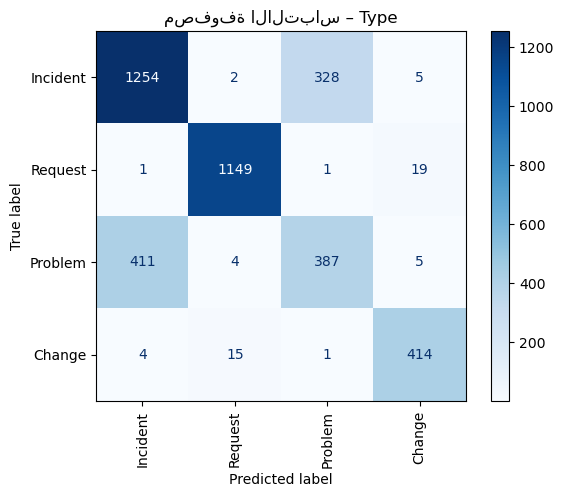

Queue | الدقة = 81.05%
                                 precision    recall  f1-score   support

               Customer Service       0.61      0.57      0.59      1158
           Billing and Payments       0.93      0.90      0.91      1197
                Product Support       0.57      0.50      0.53      1155
            Sales and Pre-Sales       0.94      0.99      0.96      1104
Service Outages and Maintenance       0.94      0.99      0.96      1193
                Human Resources       0.97      1.00      0.98      1122
          Returns and Exchanges       0.91      0.95      0.93      1192
                General Inquiry       0.97      1.00      0.98      1166
                     IT Support       0.67      0.76      0.71      1196
              Technical Support       0.53      0.45      0.49      1165

                       accuracy                           0.81     11648
                      macro avg       0.80      0.81      0.81     11648
                   weighte

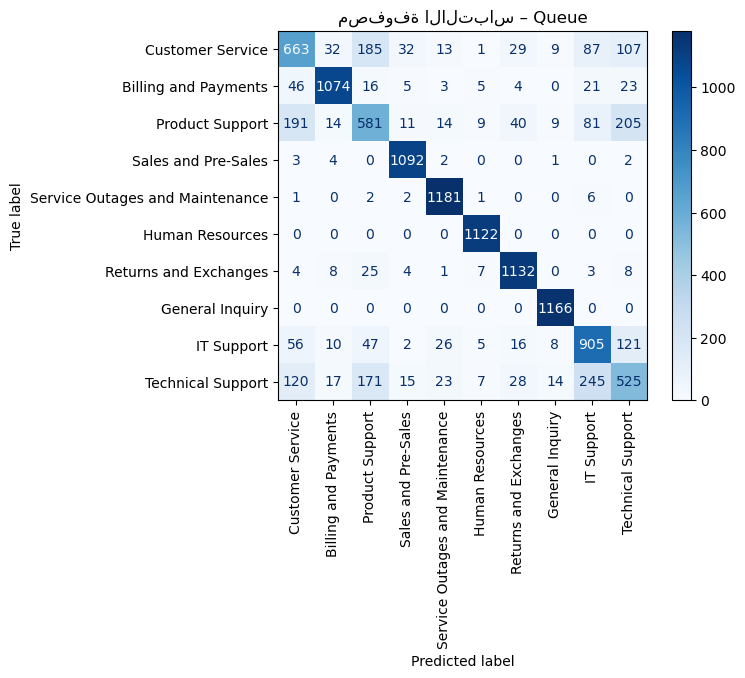

Priority | الدقة = 65.75%
              precision    recall  f1-score   support

        high       0.69      0.69      0.69      1658
         low       0.66      0.79      0.72      1604
      medium       0.61      0.49      0.55      1625

    accuracy                           0.66      4887
   macro avg       0.65      0.66      0.65      4887
weighted avg       0.65      0.66      0.65      4887



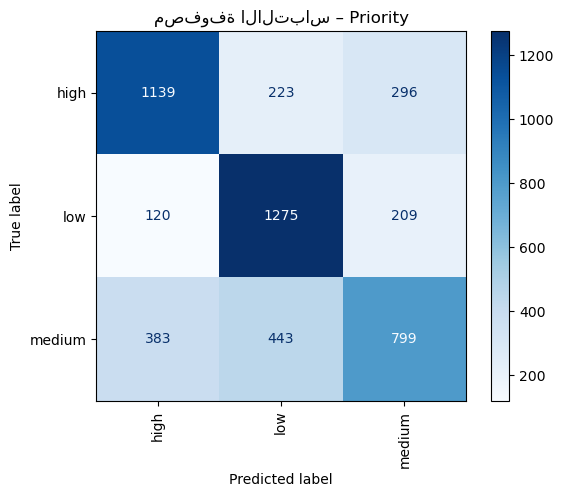

In [6]:
def analyze(trainer, ds_te, id2label, title):
    preds = trainer.predict(ds_te)
    y_pred = np.argmax(preds.predictions, axis=1)
    y_true = preds.label_ids
    acc = accuracy_score(y_true, y_pred)*100
    print(f"{title} | الدقة = {acc:.2f}%")
    print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))], zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[id2label[i] for i in id2label])
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"مصفوفة الالتباس – {title}")
    plt.show()

analyze(trainer_type, ds_type, id2label_type, "Type")
analyze(trainer_queue, ds_queue, id2label_queue, "Queue")
analyze(trainer_priority, ds_prio, id2label_priority, "Priority")


### المرحلة 6: تحليل المشاعر
استخدام نموذج DistilBERT-SST2 لتحليل المشاعر على كامل البيانات ورسم النتائج

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


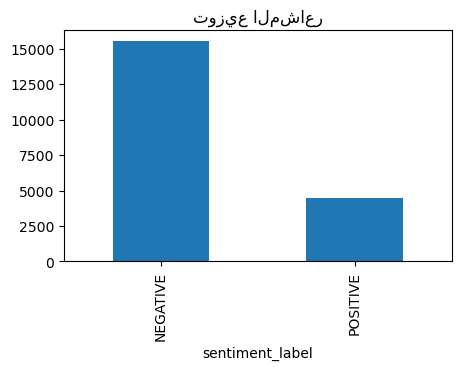

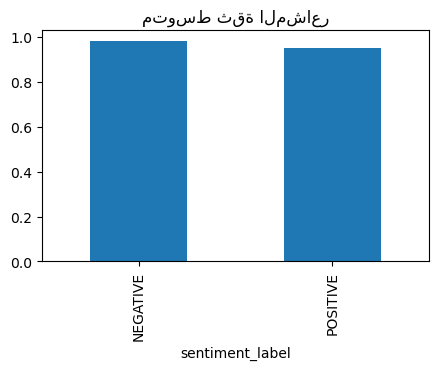

In [7]:
sent_pipe = hf_pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

batches = [df['clean_text'][i:i+32].tolist() for i in range(0, len(df), 32)]
labels, scores = [], []
for batch in batches:
    out = sent_pipe(batch, truncation=True)
    labels += [o['label'] for o in out]
    scores += [o['score'] for o in out]

df['sentiment_label'] = labels
df['sentiment_score'] = scores

plt.figure(figsize=(5,3))
df['sentiment_label'].value_counts().plot(kind='bar')
plt.title("توزيع المشاعر")
plt.show()

plt.figure(figsize=(5,3))
df.groupby('sentiment_label')['sentiment_score'].mean().plot(kind='bar')
plt.title("متوسط ثقة المشاعر")
plt.show()


### المرحلة 7: واجهة تفاعلية
إدخال نص تذكرة ثم عرض التصنيفات وتحليل المشاعر مع زر إعادة ضبط

In [9]:
from transformers import pipeline as hf_pipeline
import ipywidgets as widgets
from IPython.display import display, clear_output

# 1) اكسِر حفظ id2label من التدريب (مثال):
# هذه القواميس حصلت عليها عند تدريب BERT:
# trainer_type, ds_type, id2label_type = ...
# trainer_queue, ds_queue, id2label_queue = ...
# trainer_priority, ds_prio, id2label_priority = ...

# مثال (استبدل بالقيم الحقيقية لديك):
id2label_type = {0:'Incident',1:'Request',2:'Problem',3:'Change'}
id2label_queue = {
    0:'Technical Support',1:'Product Support',2:'Customer Service',
    3:'IT Support',4:'Billing and Payments',5:'Returns and Exchanges',
    6:'Service Outages and Maintenance',7:'Sales and Pre-Sales',
    8:'Human Resources',9:'General Inquiry'
}
id2label_priority = {0:'low',1:'medium',2:'high'}

# 2) تهيئة الـpipelines
type_pipe_ui     = hf_pipeline("text-classification",
                               model="models/type-bert",
                               tokenizer="models/type-bert")
queue_pipe_ui    = hf_pipeline("text-classification",
                               model="models/queue-bert",
                               tokenizer="models/queue-bert")
priority_pipe_ui = hf_pipeline("text-classification",
                               model="models/priority-bert",
                               tokenizer="models/priority-bert")
sent_pipe_ui     = hf_pipeline("sentiment-analysis",
                               model="distilbert-base-uncased-finetuned-sst-2-english")

# 3) إنشاء عناصر الواجهة
txt = widgets.Textarea(
    placeholder="اكتب هنا نص التذكرة...",
    layout=widgets.Layout(width='90%', height='120px'),
    description="نص التذكرة:",
    style={'description_width': 'initial'}
)
btn_classify = widgets.Button(description="تصنيف", button_style='success')
btn_reset    = widgets.Button(description="إعادة ضبط", button_style='warning')
output       = widgets.Output()

# 4) دالة التصنيف مع التفصيل:
def on_classify_clicked(_):
    with output:
        clear_output()
        t = txt.value.strip()
        if not t:
            print("يرجى إدخال نص التذكرة أولاً.")
            return

        # 4.1) Type
        r_t = type_pipe_ui(t, truncation=True)[0]
        idx_t = int(r_t['label'].split('_')[1])
        label_t = id2label_type[idx_t]
        score_t = r_t['score'] * 100

        # 4.2) Queue
        r_q = queue_pipe_ui(t, truncation=True)[0]
        idx_q = int(r_q['label'].split('_')[1])
        label_q = id2label_queue[idx_q]
        score_q = r_q['score'] * 100

        # 4.3) Priority
        r_p = priority_pipe_ui(t, truncation=True)[0]
        idx_p = int(r_p['label'].split('_')[1])
        label_p = id2label_priority[idx_p]
        score_p = r_p['score'] * 100

        # 4.4) Sentiment
        r_s = sent_pipe_ui(t, truncation=True)[0]
        label_s = r_s['label']
        score_s = r_s['score'] * 100

        # 4.5) عرض النتائج النهائية
        print(f"🔹 Type:      {label_t} ({score_t:.1f}%)")
        print(f"🔹 Queue:     {label_q} ({score_q:.1f}%)")
        print(f"🔹 Priority:  {label_p} ({score_p:.1f}%)")
        print(f"🔹 Sentiment: {label_s} ({score_s:.1f}%)")

# 5) دالة إعادة الضبط
def on_reset_clicked(_):
    txt.value = ""
    with output:
        clear_output()

# 6) ربط الأزرار
btn_classify.on_click(on_classify_clicked)
btn_reset.on_click(on_reset_clicked)

# 7) عرض الواجهة
display(widgets.VBox([
    txt,
    widgets.HBox([btn_classify, btn_reset]),
    output
]))


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
